In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import netCDF4 as nc
import datetime as dt
import cmocean
import string
import glob
from salishsea_tools import viz_tools, places,geo_tools
from salishsea_tools import evaltools as et
import scipy.stats as sst
import matplotlib as mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter
import pickle

import NorthNut as nn

%matplotlib inline

NorthNut defined variables: ig0,ig1,jg0,jg1,fformat0
NorthNut defined variables: vmask, vmask0, umask, umask0, tmask, fmask, gdept,  gdept_1d, e1t, e2t, e12t, e1f, e2f, e1v, e2u, e3t_1d
NorthNut defined variables: boxCol, colL, colR, arrowwidth, headwidth, headlength, alen, toff, apw, apk


In [2]:
ig0=nn.ig0
ig1=nn.ig1
jg0=nn.jg0
jg1=nn.jg1
tmaskDIAN=nn.tmask
umaskDIAN=nn.umask
vmaskDIAN=nn.vmask

In [3]:
sdir='/data/eolson/MEOPAR/SS36runs/linkHC201812/'
saveloc='/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/'
fformat0='%Y%m%d'
fformatM='%d%b%y'

In [4]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]

In [5]:
windlat=50.14
windlon=-125.075
windj,windi=geo_tools.find_closest_model_point(windlon,windlat,navlon,navlat)

In [6]:
# try 5/14 for  basic fig
iit=dt.datetime(2015,6,13)
fname=iit.strftime(fformatM).lower()+'/SalishSea_1h_*ptrc_T.nc'
fb=nc.Dataset(glob.glob(sdir+fname)[0])
i0=111
i1=208
j0=635
j1=798

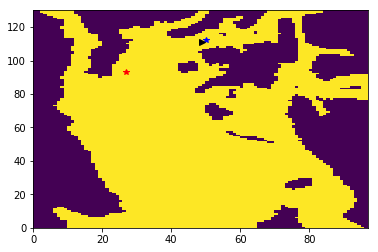

In [7]:
plt.pcolormesh(tmaskDIAN[0,:,:])
plt.plot(27,93,'r*')
plt.plot(50,112,'b*')
plt.plot(windi-ig0,windj-jg0,'k>')

In [40]:
ie1=27+ig0
je1=93+jg0
ie2=50+ig0
je2=112+jg0
bgcol='olivedrab'
#cm0=cmocean.cm.thermal
cm0=mpl.cm.get_cmap('Oranges')
#col1='navy'
#col2='darkgreen'
colc='dodgerblue'
colc2='purple'

In [9]:
t0=dt.datetime(2015,5,1) # 1st start date of run
te=dt.datetime(2015,9,1)# last start date of run
recalc=False
if recalc==True:
    ilen=(te-t0).days+1
    all1=np.zeros((ilen*24))
    all2=np.zeros((ilen*24))
    allS1=np.zeros((ilen*24))
    allS2=np.zeros((ilen*24))
    iitime=list()
    iits=t0
    iii=0
    while iits<=te:
        iitime.append(iits)
        with nc.Dataset(glob.glob(sdir+iits.strftime(fformatM).lower()+'/SalishSea_1h_*ptrc_T.nc')[0]) as fi:
            all1[iii*24:(iii+1)*24]=fi.variables['nitrate'][:,4,je1,ie1]
            all2[iii*24:(iii+1)*24]=fi.variables['nitrate'][:,4,je2,ie2]
            allS1[iii*24:(iii+1)*24]=fi.variables['nitrate'][:,0,je1,ie1]
            allS2[iii*24:(iii+1)*24]=fi.variables['nitrate'][:,0,je2,ie2]
        iii=iii+1
        iits=iits+dt.timedelta(days=1)
    iitime=np.array(iitime)
    with open('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/showPatternVarsNE.pkl','wb') as ff:
        pickle.dump([iitime,all1,all2,allS1,allS2],ff)#means1,means2,meansc,meansc2,maxs1,maxs2,maxsc,maxsc2,
else:
    ilen=(te-t0).days+1
    with open('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/showPatternVarsNE.pkl','rb') as ff:
        [iitime,all1,all2,allS1,allS2]=pickle.load(ff) #means1,means2,meansc,meansc2,maxs1,maxs2,maxsc,maxsc2,

In [10]:
it2=[t0+dt.timedelta(hours=hh) for hh in range(0,ilen*24)]
it2=np.array(it2)

In [11]:
saveloc2='/ocean/eolson/MEOPAR/analysis-elise/notebooks/NorthernNitrate/Movie/'
savef='saveWind_'+str(windlon).replace('-','m').replace('.','p')+'_'+str(windlat).replace('-','m').replace('.','p')+'.npz'
wind=np.load(saveloc2+savef)
windDates=np.array([dt.datetime(2015,1,1)+dt.timedelta(hours=ii) for ii in range(0,24*366)])

In [12]:
len(wind['winddatenum']),len(windDates)

(8784, 8784)

In [13]:
np.shape(e1t)
xx=np.cumsum(e1t[0,:,:],0)/1e3
yy=np.cumsum(e2t[0,:,:],1)/1e3

In [14]:
it0w=np.argmin(np.abs(dt.datetime(2015,5,15)-windDates)) # on
itew=np.argmin(np.abs(dt.datetime(2015,8,21)-windDates)) # off
it0w2=np.argmin(np.abs(dt.datetime(2015,5,1)-windDates)) # on
itew2=np.argmin(np.abs(dt.datetime(2015,9,1)-windDates)) # off

13 Jun 2015 00:30 UTC


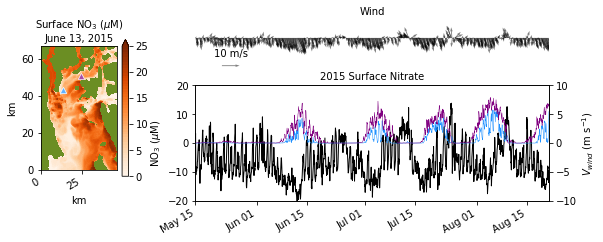

In [62]:
ih=0#10
kk=4
iit=dt.datetime(1900,1,1)+dt.timedelta(seconds=fb.variables['time_centered'][:][ih])

fig = plt.figure(figsize=(8.5,3.4))
gs1 = gridspec.GridSpec(2,2,left=.06,right=.89,hspace=0.3,wspace=.3,bottom=0.16,top=.92,width_ratios=[1,4],height_ratios=[1,2.5])
gs0=gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs1[:,0],width_ratios=[10,1],wspace=.1)
gsc=gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gs0[0,1],height_ratios=[.1,1,.1],wspace=.3)
#gs1=gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gs1[1:],height_ratios=[.5,1,.5],wspace=.1)
cbax=fig.add_subplot(gsc[1, 0])
cbax.set_aspect(20/1)
ax0=fig.add_subplot(gs0[0])
ax2=fig.add_subplot(gs1[0,1])
ax1=fig.add_subplot(gs1[1,1])
viz_tools.set_aspect(ax0)
ax0.set_facecolor(bgcol)
ax3=ax1.twinx()
ax1.set_zorder(ax3.get_zorder()+1)

iax=ax0 # fig 0: Nitrate
#kk=0
clim=(0,25)
mesh0=ax0.contourf(yy[j0:j1,i0:i1]-yy[j0,i0],xx[j0:j1,i0:i1]-xx[j0,i0],
                   np.ma.masked_where(tmask[0,kk,j0:j1,i0:i1]==0,fb.variables['nitrate'][ih,kk,j0:j1,i0:i1]),
                   np.linspace(clim[0],clim[1],50),vmin=clim[0],vmax=clim[1],
                         cmap=cm0,extend='max')
cb=fig.colorbar(mesh0,cax=cbax,ticks=np.linspace(clim[0],clim[1],6))
#test=cb.ax.yaxis.get_ticklabels()
#test[0].set_text(u'\u2264{}'.format(test[0].get_text()))
#test[-1].set_text(u'\u2265{}'.format(test[-1].get_text()))
#cb.ax.yaxis.set_ticklabels(test)
ax0.set_title('Surface NO$_3$ ($\mu$M)\nJune 13, 2015',fontsize=10)
print(iit.strftime('%d %b %Y %H:%M UTC'))
#ax0.set_xticks([],[]);
#ax0.set_yticks([],[]); 
ie1k=xx[je1,ie1]-xx[j0,i0]
je1k=yy[je1,ie1]-yy[j0,i0]
ie2k=xx[je2,ie2]-xx[j0,i0]
je2k=yy[je2,ie2]-yy[j0,i0]
#iew=xx[windj,windi]-xx[j0,i0]
#jew=yy[windj,windi]-yy[j0,i0]
ax0.plot(je1k,ie1k,'^',color='w')
ax0.plot(je1k,ie1k,'^',color=colc,markeredgecolor='w',markeredgewidth=.5,alpha=.7)
ax0.plot(je2k,ie2k,'^',color='w',markeredgecolor='w')
ax0.plot(je2k,ie2k,'^',color=colc2,markeredgecolor='w',markeredgewidth=.5,alpha=.7)
#ax0.plot(je2k,ie2k,'x',color=col2,markeredgecolor='k',markeredgewidth=.5,alpha=.7)
ax0.set_xlabel('km',fontsize=10)
ax0.set_ylabel('km',fontsize=10)
ax0.set_xlim((0,47))
ax0.set_ylim((0,67))
#ax1.plot(it2,all1,'-',color=col1,alpha=.5,linewidth=.5)
#ax1.plot(it2,all2,'-',color=col2,alpha=.5,linewidth=.5)
ax1.plot(it2,allS1,'-',color=colc,alpha=1,linewidth=.5)
ax1.plot(it2,allS2,'-',color=colc2,alpha=1,linewidth=.5)

#ax1.plot(iit,fb.variables['nitrate'][ih,kk,je1,ie1],'^',color='w',markersize=2)
#ax1.plot(iit,fb.variables['nitrate'][ih,kk,je1,ie1],'^',color=col1,markeredgecolor='w',markeredgewidth=.5,markersize=3,alpha=.7)
#ax1.plot(iit,fb.variables['nitrate'][ih,kk,je2,ie2],'^',color='w',markersize=3)
#ax1.plot(iit,fb.variables['nitrate'][ih,kk,je2,ie2],'^',color=col2,markeredgecolor='w',markeredgewidth=.5,markersize=3,alpha=.7)
#ax1.set_xlim(t0,te)
ax1.set_xlim(dt.datetime(2015,5,15),dt.datetime(2015,8,21))
ax1.set_title('2015 Surface Nitrate',fontsize=10)
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')
yearsFmt = mdates.DateFormatter('%b %d')
ax1.set_ylabel('NO$_3$ ($\mu$M)',fontsize=10)
ax1.set_ylim(-20,20)

q=ax2.quiver(wind['winddatenum'][it0w:itew:3], np.zeros(wind['winddatenum'][it0w:itew:3].shape), 
             wind['us'][it0w:itew:3], wind['vs'][it0w:itew:3],scale=200,alpha=.5)
ax2.set_xlim(wind['winddatenum'][it0w],wind['winddatenum'][itew])
qk = ax2.quiverkey(q, 0.1, -0.1, 10, '10 m/s',fontproperties={'size':10})
ax2.set_title('Wind',fontsize=10,pad=-.05)
ax2.set_axis_off()
ax1.patch.set_alpha(0)

ax3.plot(windDates[it0w2:itew2],wind['vs'][it0w2:itew2],'-',lw=1,color='k')
ax3.set_ylim(-10,10)
ax3.set_ylabel('$V_{wind}$ (m s$^{-1}$)')

ax1.xaxis.set_major_formatter(yearsFmt)
ax1.set_xticks((dt.datetime(2015,5,15),dt.datetime(2015,6,1),dt.datetime(2015,6,15),dt.datetime(2015,7,1),
                dt.datetime(2015,7,15),dt.datetime(2015,8,1),dt.datetime(2015,8,15)))
#ax1.set_position(mpl.transforms.Bbox.from_extents(0.32, 0.2, 0.99, 0.7))
#tmp=ax1.get_position()
#print(tmp)
fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/UpwellWind.png',dpi = 400, transparent=False)
fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/UpwellWind.eps',dpi = 400, transparent=False)

In [16]:
len(wind['vs'])

8784

In [17]:
len(allS2),len(wind['wind'][it0w:itew])

(2976, 2352)

### wind correlations

comments: stick with wind magnitude; otherwise direction issues complicate things- see first set of correlation plots 

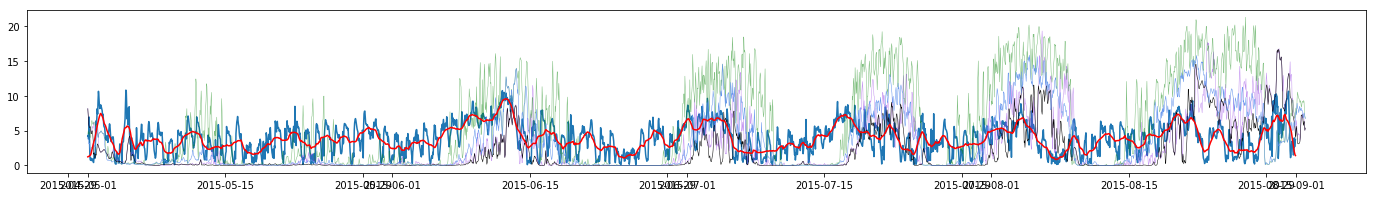

In [18]:
fig,ax=plt.subplots(1,1,figsize=(24,3))
ax.plot(windDates[it0w2:itew2],wind['wind'][it0w2:itew2])#it2,
w2=np.convolve(wind['wind'][it0w2:itew2], np.ones((24,))/24, mode='same') # do not use edges!
ax.plot(it2,all1,'-',color=col1,alpha=.5,linewidth=.5)
ax.plot(it2,all2,'-',color=col2,alpha=.5,linewidth=.5)
ax.plot(it2,allS1,'-',color=colc,alpha=1,linewidth=.5)
ax.plot(it2,allS2,'-',color=colc2,alpha=1,linewidth=.5)
ax.plot(windDates[it0w2:itew2],w2,'r-')


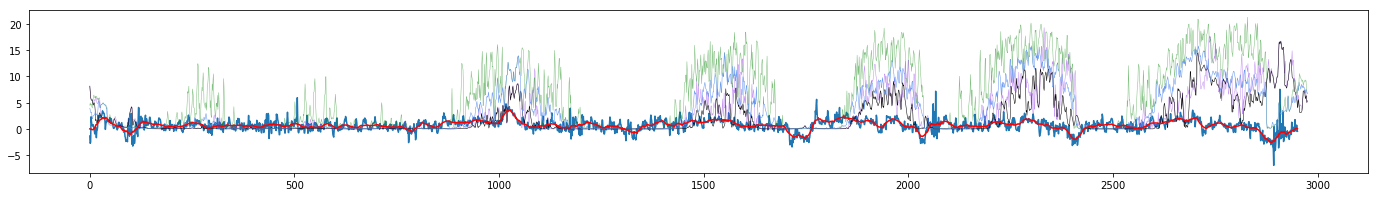

In [19]:
# U Wind
fig,ax=plt.subplots(1,1,figsize=(24,3))
ax.plot(wind['us'][it0w2:itew2])#it2,
w2=np.convolve(wind['us'][it0w2:itew2], np.ones((24,))/24, mode='same') # do not use edges!
ax.plot(all1,'-',color=col1,alpha=.5,linewidth=.5)
ax.plot(all2,'-',color=col2,alpha=.5,linewidth=.5)
ax.plot(allS1,'-',color=colc,alpha=1,linewidth=.5)
ax.plot(allS2,'-',color=colc2,alpha=1,linewidth=.5)
ax.plot(w2,'r-')

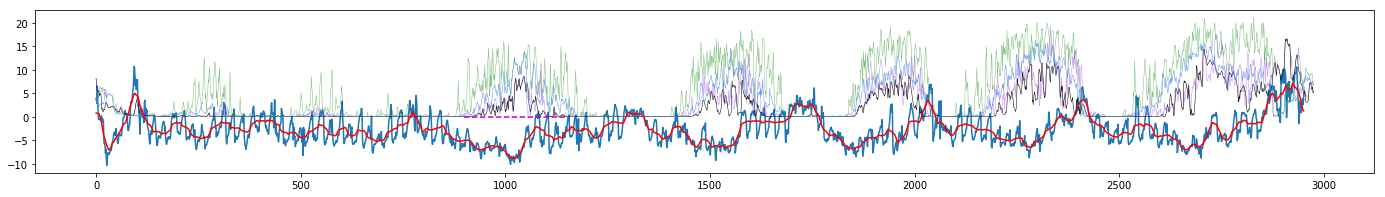

In [20]:
# V Wind
fig,ax=plt.subplots(1,1,figsize=(24,3))
ax.plot(wind['vs'][it0w2:itew2])#it2,
w2=np.convolve(wind['vs'][it0w2:itew2], np.ones((24,))/24, mode='same') # do not use edges!
ax.plot(all1,'-',color=col1,alpha=.5,linewidth=.5)
ax.plot(all2,'-',color=col2,alpha=.5,linewidth=.5)
ax.plot(allS1,'-',color=colc,alpha=1,linewidth=.5)
ax.plot(allS2,'-',color=colc2,alpha=1,linewidth=.5)
ax.plot(w2,'r-')
ax.plot((900,1150),(0,0),'m--')

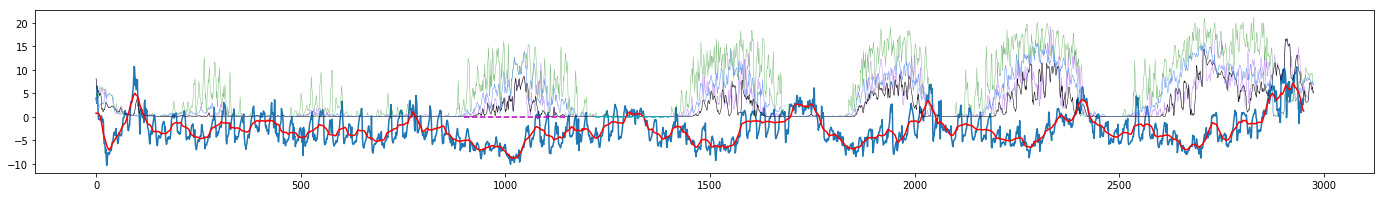

In [21]:
# V Wind
fig,ax=plt.subplots(1,1,figsize=(24,3))
ax.plot(wind['vs'][it0w2:itew2])#it2,
w2=np.convolve(wind['vs'][it0w2:itew2], np.ones((24,))/24, mode='same') # do not use edges!
ax.plot(all1,'-',color=col1,alpha=.5,linewidth=.5)
ax.plot(all2,'-',color=col2,alpha=.5,linewidth=.5)
ax.plot(allS1,'-',color=colc,alpha=1,linewidth=.5)
ax.plot(allS2,'-',color=colc2,alpha=1,linewidth=.5)
ax.plot(w2,'r-')
ax.plot((900,1150),(0,0),'m--')
ax.plot((1220,1400),(0,0),'c--')


In [ ]:
it2[900],it2[1150]

In [ ]:
it2[1220],it2[1400]

In [ ]:
# make wind and N time ranges consistent
windwind=wind['wind'][it0w2:itew2]
windus=wind['us'][it0w2:itew2]
windvs=wind['vs'][it0w2:itew2]

In [ ]:
## correlations: wind speed S1
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=windwind[(ist+ii):(ien+ii)]
    y=allS1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
for iw in range(3,48,6):
    w2=np.convolve(windwind, np.ones((iw,))/iw, mode='same')
    rsP2=list()
    for ii in range(-72,72):
        x=w2[(ist+ii):(ien+ii)]
        y=allS1[ist:ien]
        rsP2.append(sst.pearsonr(x,y)[0])
    ax.plot(iis,rsP2,label=str(iw))
plt.legend()

In [ ]:
## Wind speed 1
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=windwind[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(windwind, np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(rsP2)
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

In [ ]:
## all2, v wind component abs val only
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=np.abs(windvs[(ist+ii):(ien+ii)])
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(np.abs(windvs), np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(np.abs(rsP2))
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

In [ ]:
## all2, v wind component abs val only
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=np.abs(windvs[(ist+ii):(ien+ii)])
    y=all2[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(np.abs(windvs), np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all2[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(np.abs(rsP2))
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all2[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

In [ ]:
## allc, u wind component abs val only
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=np.abs(windus[(ist+ii):(ien+ii)])
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(np.abs(windus), np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(np.abs(rsP2))
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

In [ ]:
## allc2
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=wind['wind'][(ist+ii):(ien+ii)]
    y=allc2[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(wind['wind'], np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=allc2[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(rsP2)
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=allc2[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 16 hours earlier, ie from -28 hours to -4 hours

In [ ]:
## all1
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=wind['wind'][(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(wind['wind'], np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(rsP2)
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))

In [ ]:
## all2
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=wind['wind'][(ist+ii):(ien+ii)]
    y=all2[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(wind['wind'], np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all2[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(rsP2)
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all2[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))

### tidal velocity correlation

In [ ]:
start=dt.datetime(2015,5,12) # use even number of fortnights (6, end is included)
end=dt.datetime(2015,8,23) # end quickly for now- calculations too long
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_basedir_GLS='/data/eolson/results/MEOPAR/SS36runs/CedarRuns/GLS_Summer15/'
mod_nam_fmt='nowcast'
mod_nam_fmt_GLS='long'
mod_flen=1
mod_flen_GLS=10
saveloc='/data/eolson/results/MEOPAR/SS36runs/calcFiles/NTransport/'
fver='HC201812'

In [ ]:
# load from hindcast
fliste3t=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'carp_T',1)
flistV=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_V',1)
flistT=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)
flistB=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
flistNW=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_W',1)
flistNU=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_U',1)
flistNV=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_V',1)
flistR=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'prod_T',1)

In [ ]:
def vvl_interp_T_to_V(pe3_in,e1v,e2v,e1t,e2t,vmask,e3t_0,e3v_0):
    # see isobathPanels-Fig
    # keep extra dimensions in mesh variables
    e12v = e1v[0,:,:]*e2v[0,:,:]
    e12t = e1t[0,:,:]*e2t[0,:,:]
    pe3_out=np.zeros(np.shape(pe3_in))
    pe3_out[:,:,:-1,:-1]=.5*vmask[:,:,:-1,:-1]/e12v[:-1,:-1]*(e12t[:-1,:-1]*(pe3_in[:,:,:-1,:-1]-e3t_0[:,:,:-1,:-1])+e12t[1:,:-1]*(pe3_in[:,:,1:,:-1]-e3t_0[:,:,1:,:-1]))
    pe3_out=pe3_out+e3v_0
    return pe3_out

In [ ]:
mesh=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc')
#bathyf=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
vmask=mesh.variables['vmask'][:,:,:,:]
e1t=mesh.variables['e1t'][:,:,:]
e2t=mesh.variables['e2t'][:,:,:]
e1v=mesh.variables['e1v'][:,:,:]
e2v=mesh.variables['e2v'][:,:,:]
e3t_0=mesh.variables['e3t_0'][:,:,:,:]
e3v_0=mesh.variables['e3v_0'][:,:,:,:]
mesh.close()

In [ ]:
test=vvl_interp_T_to_V(e3t_0,e1v,e2v,e1t,e2t,vmask,e3t_0,e3v_0)

In [ ]:
vti=list()
sti=list()
for iif in range(0,len(flistV)):
    if (iif%10)==0:
        print('iif=',iif)  
    with nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fC,\
            nc.Dataset(flistV.loc[iif,['paths']].values[0]) as fV,\
              nc.Dataset(flistT.loc[iif,['paths']].values[0]) as fT:
        # extract fields to numpy variables for faster transect extraction:
        sshe=np.copy(fT.variables['sossheig'][:,jg0:jg1,ig0:ig1])
        e3te=np.copy(fC.variables['e3t'][:,:,jg0:jg1,ig0:ig1])
        vvele=np.copy(fV.variables['vomecrty'][:,:,jg0:jg1,ig0:ig1])
    e3v=vvl_interp_T_to_V(e3te,e1v[:,jg0:jg1,ig0:ig1],e2v[:,jg0:jg1,ig0:ig1],e1t[:,jg0:jg1,ig0:ig1],
                          e2t[:,jg0:jg1,ig0:ig1],vmask[:,:,jg0:jg1,ig0:ig1],e3t_0[:,:,jg0:jg1,ig0:ig1],e3v_0[:,:,jg0:jg1,ig0:ig1])
    # 1st extract Discovery mouth transect for diagnosing tidal phase:
    vti.append(np.sum(np.sum(vmaskDIAN[:26,93,9:16]*vvele[:,:26,93,9:16]*e3v[:,:26,93,9:16],2),1)/np.sum(np.sum(e3v[:,:26,93,9:16],2),1))
    sti.append(np.sum(tmaskDIAN[0,93,9:16]*sshe[:,93,9:16],1)/np.sum(tmaskDIAN[0,93,9:16]))
vt=np.concatenate(vti,axis=0)
st=np.concatenate(sti,axis=0)
del vti, sti

In [ ]:
tv=np.array([start+dt.timedelta(hours=ii) for ii in range(0,int((end-start).total_seconds()/3600+24))])

In [ ]:
plt.plot(vt)
len(vt),len(allc[ist:ien]),len(tv)

In [ ]:
## allc
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
istv=np.argmin(np.abs(dt.datetime(2015,5,15)-tv)) # on
ienv=np.argmin(np.abs(dt.datetime(2015,8,21)-tv)) # off
for ii in range(-24,24):
    iis.append(ii)
    x=vt[(istv+ii):(ienv+ii)]
    y=allc[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
iii=np.argmax(rsP)
print(iis[iii],rsP[iii],'rsquared:',rsP[iii]*rsP[iii])
x=vt[(istv+iis[iii]):(ienv+iis[iii])]
y=allc[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))

In [ ]:
## allc2
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
istv=np.argmin(np.abs(dt.datetime(2015,5,15)-tv)) # on
ienv=np.argmin(np.abs(dt.datetime(2015,8,21)-tv)) # off
for ii in range(-24,24):
    iis.append(ii)
    x=vt[(istv+ii):(ienv+ii)]
    y=allc2[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
iii=np.argmax(rsP)
print(iis[iii],rsP[iii],'rsquared:',rsP[iii]*rsP[iii])
x=vt[(istv+iis[iii]):(ienv+iis[iii])]
y=allc2[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))

In [ ]:
## all1
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
istv=np.argmin(np.abs(dt.datetime(2015,5,15)-tv)) # on
ienv=np.argmin(np.abs(dt.datetime(2015,8,21)-tv)) # off
for ii in range(-12,12):
    iis.append(ii)
    x=vt[(istv+ii):(ienv+ii)]
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
iii=np.argmax(rsP)
print(iis[iii],rsP[iii],'rsquared:',rsP[iii]*rsP[iii])
x=vt[(istv+iis[iii]):(ienv+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::3],y[::3]))

In [ ]:
## all2
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
istv=np.argmin(np.abs(dt.datetime(2015,5,15)-tv)) # on
ienv=np.argmin(np.abs(dt.datetime(2015,8,21)-tv)) # off
for ii in range(-12,12):
    iis.append(ii)
    x=vt[(istv+ii):(ienv+ii)]
    y=all2[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
iii=np.argmax(rsP)
print(iis[iii],rsP[iii],'rsquared:',rsP[iii]*rsP[iii])
x=vt[(istv+iis[iii]):(ienv+iis[iii])]
y=all2[ist:ien]
print(sst.pearsonr(x,y))
print(sst.pearsonr(x[::3],y[::3]))